# Linear regression

In this tutorial, we build a linear regression model with Liesel and estimate it with Goose. Our goal is to illustrate the most important features of the software in a straightforward context.

## Model building with Liesel

Liesel is based on the concept of probabilistic graphical models (PGMs) to represent (primarily Bayesian) statistical models, so let us start with a very brief look at what PGMs are and how they are implemented in Liesel.

### Probabilistic graphical models

In a PGM, each variable is represented as a node. There are two basic types of nodes in Liesel: strong and weak nodes. A strong node is a node whose value is defined "outside" of the model, for example, if the node represents some observed data or a parameter (parameters are usually set by an inference algorithm such as an optimizer or sampler). In contrast, a weak node is a node whose value is defined "within" the model, that is, it is a deterministic function of some other nodes. An exp-transformation mapping a real-valued parameter to a positive number, for example, would be a weak node.

In addition, each node can have an optional probability distribution. The probability density or mass function of the distribution evaluated at the value of the node gives its log-probability. In a typical Bayesian regression model, the response node would have a normal distribution and the parameter nodes would have some prior distribution (for example, a normal-inverse-gamma prior). The following table shows the different node types and some examples of their use cases.

|                          | **Strong node**                | **Weak node**                                        |
|--------------------------|--------------------------------|------------------------------------------------------|
| **With distribution**    | Response, parameter, ...       | Copula, ...                                          |
| **Without distribution** | Covariate, hyperparameter, ... | Inverse link function, parameter transformation, ... |

A PGM is essentially a collection of connected nodes. Two nodes can be connected through a directed edge, meaning that the first node is an input for the value or the distribution of the second node. Nodes *without* an edge between them are assumed to be conditionally independent, allowing us to factorize the model log-probability as

$$\log p(\text{Model}) = \sum_{\text{Node $\in$ Model}} \log p(\text{Node} \mid \text{Inputs}(\text{Node})).$$

### Generating the data

Before we can generate the data and build the model graph, we need to load Liesel and a number of other packages. We usually import the model building library `liesel.liesel` as `lsl`, and the MCMC library `liesel.goose` as `gs`.

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.liesel as lsl
import matplotlib.pyplot as plt
import numpy as np
from liesel.liesel.goose import make_log_prob_fn

rng = np.random.default_rng(42)

Now we can simulate 500 observations from the linear regression model $y_i \sim \mathcal{N}(\beta_0 + \beta_1 x_i, \;\sigma^2)$ with the true parameters $\boldsymbol{\beta} = (\beta_0, \beta_1)' = (1, 2)'$ and $\sigma = 1$. The relationship between the response $y_i$ and the covariate $x_i$ is visualized in the following scatterplot.

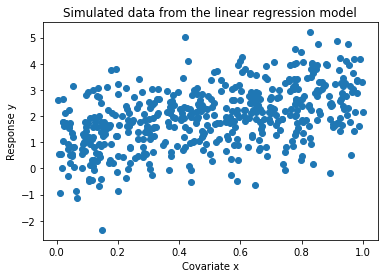

In [2]:
# sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# data-generating process

x0 = rng.uniform(size=n)
X = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
y = X @ true_beta + eps

# plot the simulated data

plt.scatter(x0, y)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

### Building the model graph

The graph of a Bayesian linear regression model is a tree, where the hyperparameters of the prior are the leaves and the response is the root. To build this tree in Liesel, we need to start from the leaves and work our way down to the root. Let's assume the weakly informative prior $\beta_0, \beta_1 \sim \mathcal{N}(0, 100)$ for the regression coefficients. To encode this assumption in Liesel, we need to create two hyperparameter nodes (`lsl.Hyperparameter`) for the mean and the standard deviation of the normal prior. Setting a name when creating a node is optional but helps to identify it later.

In [3]:
n_beta_loc = lsl.Hyperparameter(0.0, name="beta_loc")
n_beta_scale = lsl.Hyperparameter(100.0, name="beta_scale")

n_beta_loc

Hyperparameter(Node(0.0, name='beta_loc'))

In [4]:
n_beta_scale

Hyperparameter(Node(100.0, name='beta_scale'))

Now, let's create the node for the regression coefficients (`lsl.RegressionCoef`). To do so, we need to define its initial value and its node distribution (`lsl.NodeDistribution`). Here, the node distribution is initialized with three arguments: a string identifying [the normal distribution in TensorFlow Probability (TFP)](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Normal), and the nodes representing its parameters (the mean parameter is called `loc` in TFP, and the standard deviation parameter is called `scale`).

In [5]:
n_beta = lsl.RegressionCoef(
    value=np.array([0.0, 0.0]),
    distribution=lsl.NodeDistribution("Normal", loc=n_beta_loc, scale=n_beta_scale),
    name="beta",
)

n_beta

RegressionCoef(Node(array(...), NodeDistribution('Normal', loc=Hyperparameter(..., name='beta_loc'), scale=Hyperparameter(..., name='beta_scale')), name='beta'))

The second branch of the tree is for the residual standard deviation. We build it in a similar way, but this time, using the weakly informative prior $\sigma \sim IG(0.01, 0.01)$ and the `lsl.Parameter` class instead of the `lsl.RegressionCoef` class. By the way, the regression coefficient class is a subclass of the parameter class and behaves exactly the same, but it describes the role of the regression coefficients in the model more precisely.

In [6]:
n_sigma_a = lsl.Hyperparameter(0.01, name="a")
n_sigma_b = lsl.Hyperparameter(0.01, name="b")

n_sigma = lsl.Parameter(
    value=10.0,
    distribution=lsl.NodeDistribution(
        "InverseGamma", concentration=n_sigma_a, scale=n_sigma_b
    ),
    name="sigma",
)

n_sigma

Parameter(Node(10.0, NodeDistribution('InverseGamma', concentration=Hyperparameter(..., name='a'), scale=Hyperparameter(..., name='b')), name='sigma'))

All nodes we have seen so far are strong nodes. Before we can create a weak node that computes the predictions $\hat{\boldsymbol{y}} = \mathbf{X}\boldsymbol{\beta}$, we need to set up one more strong node for the design matrix (`lsl.DesignMatrix`). To compute the matrix-vector product $\hat{\boldsymbol{y}} = \mathbf{X}\boldsymbol{\beta}$, we can use a weak smooth node (`lsl.Smooth`). Liesel comes with a number of default weak nodes, but the user can also implement their own specialized weak nodes.

In [7]:
n_X = lsl.DesignMatrix(X, name="X")
n_y_hat = lsl.Smooth(n_X, n_beta, name="y_hat")
n_y_hat

Smooth(Node(SmoothCalculator(x=DesignMatrix(..., name='X'), ...), name='y_hat'))

Finally, we can connect the branches of the tree in a response node (`lsl.Response`). The value of the node is the simulated response vector, the node `n_y_hat` represents the mean, and `n_sigma` the standard deviation of the node distribution.

In [8]:
n_y = lsl.Response(
    value=y,
    distribution=lsl.NodeDistribution("Normal", loc=n_y_hat, scale=n_sigma),
    name="y",
)

n_y

Response(Node(array(...), NodeDistribution('Normal', loc=Smooth(..., name='y_hat'), scale=Parameter(..., name='sigma')), name='y'))

The easiest way to combine several nodes in a model object is using the model builder (`lsl.ModelBuilder`). Nodes can be added step by step to the builder. Here, we are only adding the response node, but the builder takes care of adding all missing direct or indirect inputs to the model when the `build()` method is called. The model that is returned by the builder provides a couple of convenience function, for example, to evaluate the model log-probability, or to update the nodes in a topological order.

In [9]:
mb = lsl.ModelBuilder()
mb.add_nodes(n_y)
model = mb.build()
model

Model([DesignMatrix(..., name='X'), Hyperparameter(..., name='a'), Hyperparameter(..., name='b'), ...])

The `lsl.plot_model()` function visualizes the graph of a model. Strong nodes are shown in blue, weak nodes in red. Nodes with a probability distribution are highlighted with a star. In the figure below, we can see the tree-like structure of the graph and identify the two branches for the mean and the standard deviation of the response. By the way, if the layout of the graph looks messy for you, please make sure you have the `pygraphviz` package installed.

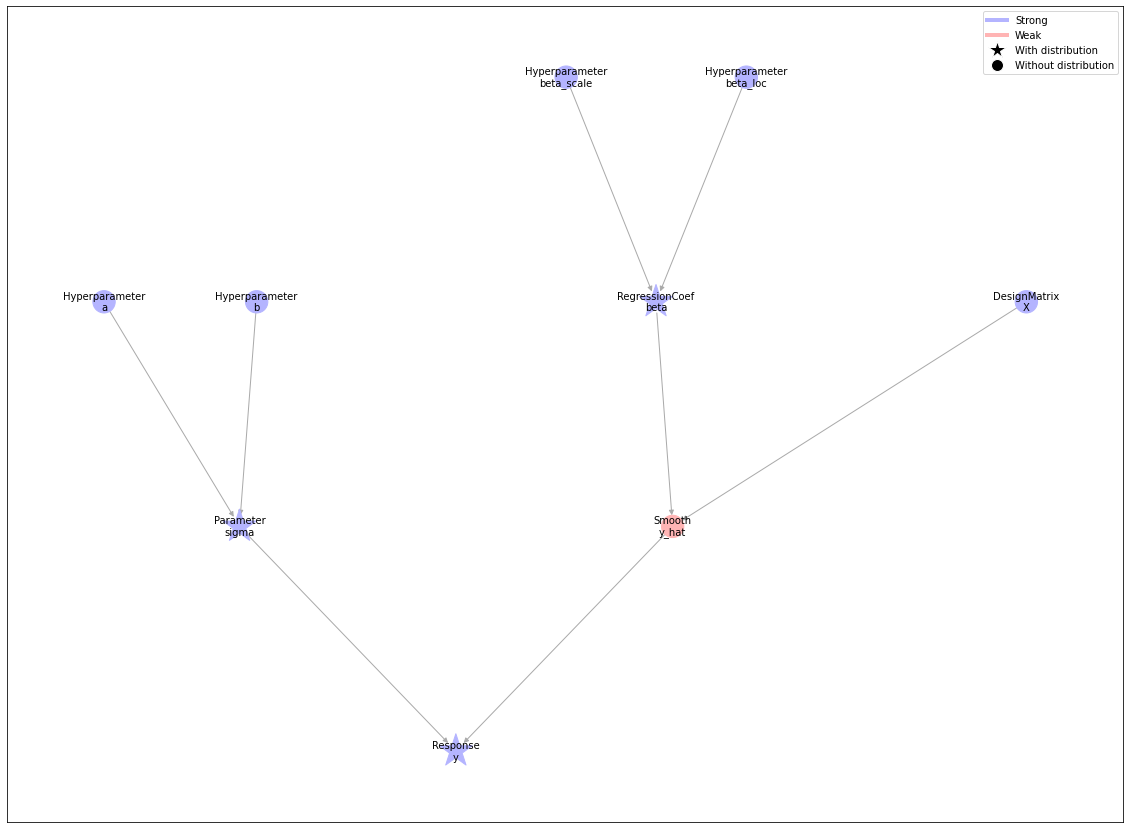

In [10]:
lsl.plot_model(model)

### Node and model log-probabilities

The log-probability of the model, which can be interpreted as the (unnormalized) log-posterior in a Bayesian context, can be accessed with the `log_prob` property.

In [11]:
model.log_prob

-1641.434182772623

The individual nodes also have a `log_prob` property. In fact, because of the conditional independence assumption of the model, the log-probability of the model is given by the sum of the log-probabilities of the nodes with probability distributions.

In [12]:
n_beta.log_prob + n_sigma.log_prob + n_y.log_prob

-1641.434182772623

Nodes without a probability distribution return a log-probability of zero.

In [13]:
n_beta_loc.log_prob

0.0

The log-probability of a node depends on its value and its inputs. Thus, if we change the standard deviation of the response from 10 to 1, the log-probability of the corresponding node, the log-probability of the response node, and the log-probability of the model change as well.

In [14]:
print(f"Old value of sigma: {n_sigma.value}")
print(f"Old log-prob of sigma: {n_sigma.log_prob}")
print(f"Old log-prob of y: {n_y.log_prob}\n")

n_sigma.value = 1.0

print(f"New value of sigma: {n_sigma.value}")
print(f"New log-prob of sigma: {n_sigma.log_prob}")
print(f"New log-prob of y: {n_y.log_prob}\n")

print(f"New model log-prob: {model.log_prob}")

Old value of sigma: 10.0
Old log-prob of sigma: -6.9721421531563434
Old log-prob of y: -1623.4138228460292

New value of sigma: 1.0
New log-prob of sigma: -4.6555311772972345
New log-prob of y: -1724.670241269328

New model log-prob: -1740.3739902200628


For most inference algorithms, we need the gradient of the model log-probability with respect to the parameters. Liesel uses [the JAX library for numerical computing and machine learning](https://github.com/google/jax) to compute gradients using automatic differentiation. The gradient with respect to the standard deviation of the response can be computed with the `grad()` method of the corresponding node.

In [15]:
n_sigma.grad()

INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO - Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


array(2029.4019, dtype=float32)

### Pure, stateless JAX functions

Liesel's nodes are stateful, that is, their state consisting of the value and the log-probability are stored in the object. The state of a node can be accessed with the `state` property, which returns a named tuple.

In [16]:
n_beta.state

NodeState(value=array([0., 0.]), log_prob=-11.0482177734375)

In [17]:
n_sigma.state

NodeState(value=1.0, log_prob=-4.6555311772972345)

The state of a model is defined as a dictionary of node states. The dictionary keys correspond to the node names.

In [18]:
model.state.keys()

dict_keys(['X', 'a', 'b', 'beta_scale', 'beta_loc', 'sigma', 'beta', 'y_hat', 'y'])

At first, the stateful Liesel objects seem incompatible with JAX' pure functional programming paradigm (JAX' ["anima di pura programmazione funzionale"](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)), but it is possible to separate the math and the data that are stored in the objects to use them with JAX. We have already seen how to extract the state, that is, the data from the model, so now we need to generate a pure, stateless function that computes the log-probability from the model state.

The function `liesel.liesel.goose.make_log_prob_fn()` serves this exact purpose. The returned log-probability function requires two arguments: the model state as the second argument, and a position, that is, a subset of the model state defining with respect to which nodes the log-probability is evaluated, as the first argument. The position is important when computing the derivatives of the log-probability.

Usually, the user doesn't need to import or use the `make_log_prob_fn()` function, because the MCMC framework Goose hides this level of complexity, but it is important for a good understanding of the Liesel internals.

In [19]:
model.jaxify()

log_prob_fn = make_log_prob_fn(model)
log_prob_fn({"sigma": 1.0}, model.state)

DeviceArray(-1740.374, dtype=float32)

Now we can use the functions `jax.grad()` and `jax.hessian()` to compute the first and second derivatives of the log-probability function with respect to the residual standard deviation.

In [20]:
grad_fn = jax.grad(log_prob_fn)
grad_fn({"sigma": 1.0}, model.state)

{'sigma': DeviceArray(2029.4019, dtype=float32, weak_type=True)}

In [21]:
hessian_fn = jax.hessian(log_prob_fn)
hessian_fn({"sigma": 1.0}, model.state)

{'sigma': {'sigma': DeviceArray(-7090.2163, dtype=float32, weak_type=True)}}

JAX does not only support automatic differentiation but also vectorization, parallelization, and just-in-time (JIT) compilation. If you haven't used JAX before, we highly recommend trying it out.

## MCMC inference with Goose

This section illustrates the key features of Liesel's MCMC framework Goose. To use Goose, the user needs to select one or more sampling algorithms, called (transition) kernels, for the model parameters. Goose comes with a number of standard kernels such as Hamiltonian Monte Carlo (`gs.HMCKernel`) or the No U-Turn Sampler (`gs.NUTSKernel`). Multiple kernels can be combined in one sampling scheme and assigned to different parameters, and the user can implement their own problem-specific kernels, as long as they are compatible with the `liesel.goose.kernel.Kernel` protocol. In any case, the user is responsible for constructing a *mathematically valid* algorithm.

We start with a very simple sampling scheme, keeping $\sigma$ fixed at the true value and using a NUTS sampler for $\boldsymbol{\beta}$. The kernels are added to a `gs.Engine`, which coordinates the sampling, including the kernel tuning during the warmup, and the MCMC bookkeeping. The engine can be configured step by step with a `gs.EngineBuilder`. We need to inform the builder about the model, the initial values, the kernels, and the sampling duration. Finally, we can call the `build()` method, which returns a fully configured engine.

In [22]:
n_sigma.value = true_sigma

builder = gs.EngineBuilder(seed=1337, num_chains=4)

builder.set_model(lsl.GooseModel(model))
builder.set_initial_values(model.state)

builder.add_kernel(gs.NUTSKernel(["beta"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

engine = builder.build()

Now we can run the MCMC algorithm for the specified duration by calling the `sample_all_epochs()` method on the engine. In a first step, the model and the sampling algorithm are compiled, so don't worry if you don't see an output right away. The subsequent samples will be generated much faster. Finally, we can extract the results and print a summary table.

In [23]:
engine.sample_all_epochs()
results = engine.get_results()
gs.Summary.from_result(results)

INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 4, 3, 2 / 75 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 3, 1, 1 / 25 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 3, 1, 1 / 50 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 0, 2, 1 / 100 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 200 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 2, 2, 1 / 200 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 500 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 1, 4, 1 / 500 transitions
INFO - Finishe

,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
beta,"(0,)",4000,0.980407,0.007680,0.087638,1.002038,1063.822616,1309.641743,0.002693,0.001905,0.835393,0.981402,1.126537,0.841620,1.130030
beta,"(1,)",4000,1.916127,0.023023,0.151735,1.004298,1100.874398,1152.455924,0.004586,0.003265,1.664341,1.917229,2.169653,1.691886,2.194849


If we need more samples, we can append another epoch to the engine and sample it by calling either the `sample_next_epoch()` or the `sample_all_epochs()` method. The epochs are described by `gs.EpochConfig` objects.

In [24]:
engine.append_epoch(
    gs.EpochConfig(gs.EpochType.POSTERIOR, duration=1000, thinning=1, optional=None)
)

engine.sample_next_epoch()

INFO - Finished warmup
INFO - Starting epoch: POSTERIOR, 1000 transitions, 25 jitted together
INFO - Finished epoch


No compilation is required at this point, so this is pretty fast.

### Using a Gibbs kernel

Using a Gibbs kernel is a bit more complicated, because Goose doesn't automatically derive the full conditional from the model graph. Hence, the user needs to provide a function to sample from the full conditional. The function needs to accept a PRNG state and a model state as arguments, and it needs to return a dictionary with the node name as the key and the new node value as the value. We could also update multiple parameters with one Gibbs kernel if we returned a dictionary of length two or more.

In [25]:
def draw_sigma(prng_key, model_state):
    a_prior = model_state["a"].value
    b_prior = model_state["b"].value
    n = len(model_state["y"].value)

    resid = model_state["y"].value - model_state["y_hat"].value

    a_gibbs = a_prior + n / 2
    b_gibbs = b_prior + jnp.sum(resid**2) / 2
    draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)
    return {"sigma": draw}

We build the engine in a similar way as before, but this time adding the Gibbs kernel as well.

In [26]:
builder = gs.EngineBuilder(seed=1338, num_chains=4)

builder.set_model(lsl.GooseModel(model))
builder.set_initial_values(model.state)

builder.add_kernel(gs.NUTSKernel(["beta"]))
builder.add_kernel(gs.GibbsKernel(["sigma"], draw_sigma))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

engine = builder.build()
engine.sample_all_epochs()

INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 5, 2, 4 / 75 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 1, 3, 1 / 25 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 0, 2, 2, 1 / 50 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 2, 1, 1 / 100 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 200 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 3, 1, 1 / 200 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 500 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 4, 1, 3 / 500 transitions
INFO - Finishe

Goose provides a couple of convenient numerical and graphical summary tools. The `gs.Summary` class computes several summary statistics that can be either accessed programmatically or displayed as a summary table.

In [27]:
results = engine.get_results()
gs.Summary.from_result(results)

,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
beta,"(0,)",4000,0.982895,0.009143,0.095619,1.006635,1051.482821,1139.811077,0.002939,0.002079,0.821030,0.983082,1.140303,0.835587,1.152149
beta,"(1,)",4000,1.909422,0.028126,0.167708,1.005521,1027.678752,1075.492580,0.005249,0.003756,1.634282,1.908435,2.187755,1.617327,2.163492
sigma,(),4000,1.043693,0.004291,0.065507,1.000399,3816.935532,3698.177210,0.001060,0.000750,0.941766,1.041514,1.155415,0.941673,1.155402


The effective sample sizes `ess_bulk` and `ess_tail` seem rather low compared to the 4000 MCMC samples. We can plot the trace plots of the chains with `gs.plot_trace()`.

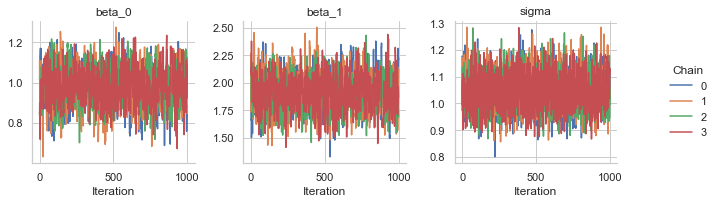

In [28]:
g = gs.plot_trace(results)

We could also take a look at a kernel density estimator with `gs.plot_density()` and the estimated autocorrelation with `gs.plot_cor()`. Alternatively, we can output all three diagnostic plots together with `gs.plot_param()`. The following plot shows the parameter $\beta_0$.

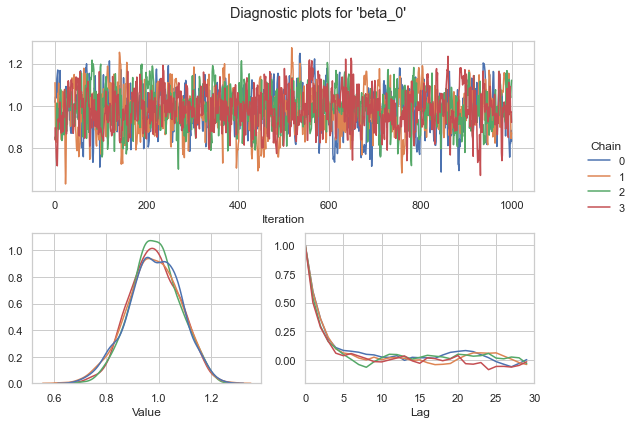

In [29]:
gs.plot_param(results, param="beta", param_index=0)

### Parameter transformations

Maybe the reason for the low effective sample size is the Metropolis-in-Gibbs sampling scheme? Let's try to sample the full parameter vector $(\boldsymbol{\beta}', \sigma)'$ with a single NUTS kernel instead. Since the standard deviation is a positive-valued parameter, we need to log-transform it to sample it with a NUTS kernel. The model class provides the `transform_parameter()` method for this purpose. The method returns a deep copy of the model with the transformed parameter.

In [30]:
model = model.transform_parameter("sigma", "Log")

The response distribution still requires the standard deviation on the original scale. The model graph shows that the back-transformation from the logarithmic to the original scale is performed by a bijector node (`lsl.Bijector`) between the transformed standard deviation and the response.

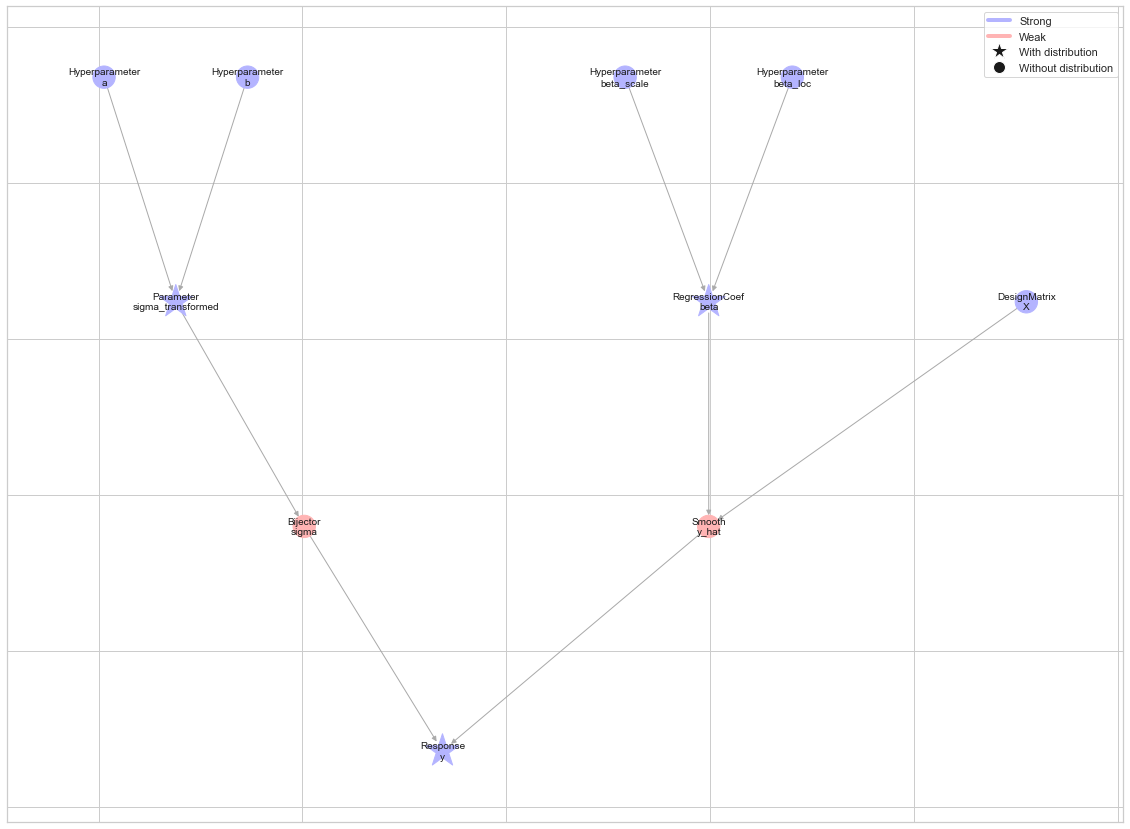

In [31]:
lsl.plot_model(model)

Now we can set up and run an MCMC algorithm with a NUTS kernel for all parameters.

In [32]:
builder = gs.EngineBuilder(seed=1339, num_chains=4)

builder.set_model(lsl.GooseModel(model))
builder.set_initial_values(model.state)

builder.add_kernel(gs.NUTSKernel(["beta", "sigma_transformed"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

# by default, goose only stores the parameters specified in the kernels.
# let's also store the standard deviation on the original scale.
builder.positions_included = ["sigma"]

engine = builder.build()
engine.sample_all_epochs()

INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 3, 2, 3, 3 / 75 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 1, 1, 1 / 25 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 50 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 2, 3, 1 / 100 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 200 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 1, 3, 5 / 200 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 500 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 2, 2, 3 / 500 transitions
INFO - Finishe

Judging from the trace plots, it seems that all chains have converged.

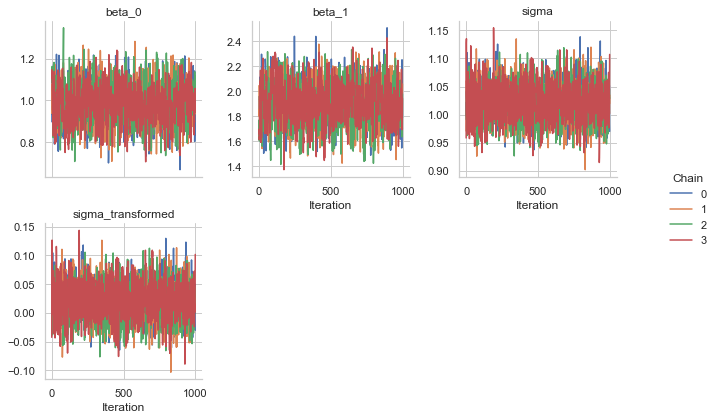

In [33]:
results = engine.get_results()
g = gs.plot_trace(results)

We can also take a look at the summary table, which includes the original $\sigma$ and the transformed $\log(\sigma)$.

In [34]:
gs.Summary.from_result(results)

,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
beta,"(0,)",4000,0.987944,0.008611,0.092795,1.002076,1417.495808,1913.239419,0.002466,0.001750,0.836045,0.988154,1.141086,0.826304,1.130906
beta,"(1,)",4000,1.901587,0.026527,0.162872,1.002851,1368.176991,1601.740436,0.004401,0.003113,1.632509,1.899962,2.174218,1.658338,2.196309
sigma,(),4000,1.021342,0.001083,0.032903,1.000665,2643.274509,2331.786419,0.000640,0.000453,0.967742,1.020613,1.076472,0.963692,1.071824
sigma_transformed,(),4000,0.020600,0.001036,0.032185,1.000665,2643.303047,2331.786419,0.000626,0.000511,-0.032790,0.020404,0.073689,-0.030206,0.075644


The effective sample size is higher for $\sigma$ than for $\boldsymbol{\beta}$. Finally, let's check the autocorrelation of the samples.

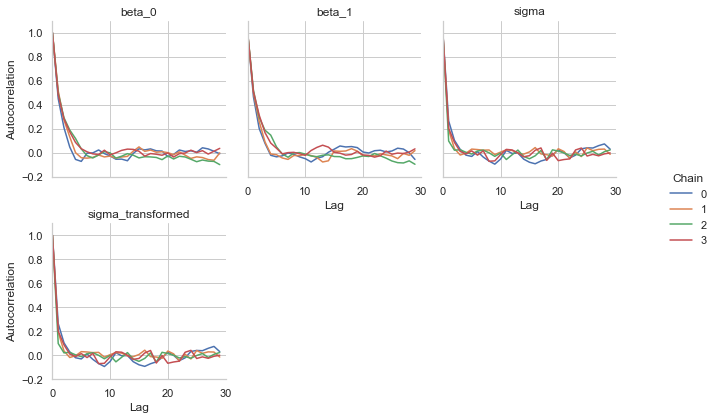

In [35]:
g = gs.plot_cor(results)